In [1]:
import numpy as np
from scipy.optimize import fminbound
import matplotlib.pyplot as plt

from optimalgrowth_loglinear import LogLinearOG

# Solve over a Grid

In [2]:
#-LogLinear Optimal Growth Problem-#
lg = LogLinearOG()
# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star = lg.v_star

In [3]:
grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)

#-Compute Required Info-#
w = v_star(grid)
u = np.log
f = lambda k: k**alpha
shocks = np.exp(mu + s * np.random.randn(shock_size))
w_func = lambda x: np.interp(x, grid, w)
Tw = np.empty_like(w)

In [4]:
%%timeit 
#-Iteration-#
for i, y in enumerate(grid):
    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    def objective(c):
        return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
    c_star = fminbound(objective, 1e-10, y)
    Tw[i] = - objective(c_star)

134 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
Tw[0]

-51.504019079050288

# Using Dask to Compute Grid

In [6]:
import dask
from dask.distributed import Client
client = Client()
print(client)

<Client: scheduler='tcp://127.0.0.1:33985' processes=8 cores=8>


In [7]:
def generate_objective(y):
    return lambda c: - u(c) - beta * np.mean(w_func(f(y - c) * shocks))

In [8]:
#Delayed Computation using same parameters as above#
Tw_dask_delayed = []
#-Iteration-#
for i, y in enumerate(grid):
    objfunc = dask.delayed(generate_objective)(y)
    c_star = dask.delayed(fminbound)(objfunc, 1e-10, y)
    Tw_dask_delayed.append(-1 * dask.delayed(objfunc)(c_star))

In [9]:
%%timeit
Tw_dask = np.array(dask.compute(*Tw_dask_delayed))

364 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
Tw_dask = np.array(dask.compute(*Tw_dask_delayed))

In [11]:
Tw_dask[0]

-51.504019079050288

In [12]:
Tw[0]

-51.504019079050288

In [13]:
np.allclose(Tw, Tw_dask)

True

While the **correct** data is computed this is much slower due to the interprocess overhead that dask introduces. 

Currently dask introduces around **100ms** of overhead for the scheduler. 

http://dask.pydata.org/en/latest/shared.html

Dask is doing a lot of coordination work that is inefficient for this computation. We get better performance on a single core.


# Larger Problems

In [14]:
"""
Filename: optgrowth.py
Authors: John Stachurski, Thomas Sargent

Solving the optimal growth problem via value function iteration.  The model is
described in 

    http://quant-econ.net/py/optgrowth.html
"""

import numpy as np
from scipy.optimize import fminbound


def bellman_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

## Serial Version

In [15]:
%matplotlib inline

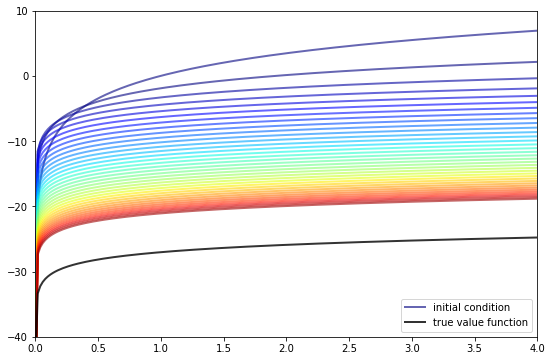

In [16]:
w = 5 * np.log(grid)  # An initial condition
n = 35
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-40, 10)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i in range(n):
    w = bellman_operator(w,
                         grid,
                         beta,
                         np.log,
                         lambda k: k**alpha,
                         shocks)

    ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

lb = 'true value function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='lower right');

## Construct Plot Separately

In [18]:
vals = []
w = 5 * np.log(grid)  # An initial condition
n = 35
for i in range(n):
    w = bellman_operator(w,
                         grid,
                         beta,
                         np.log,
                         lambda k: k**alpha,
                         shocks)
    vals.append(w)

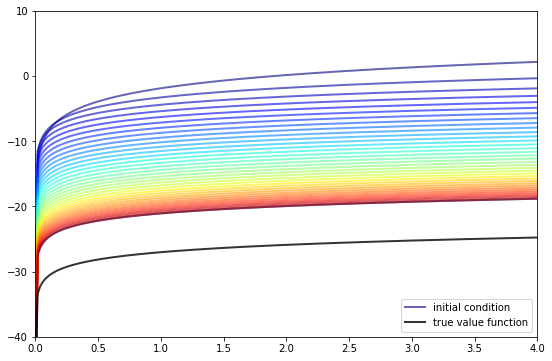

In [19]:
# Construct Plot Separately
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-40, 10)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i,w in enumerate(vals):
    ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
lb = 'true value function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='lower right');

In [20]:
%%timeit
# Computational Expensive Part of this Problem
vals = []
w = 5 * np.log(grid)  # An initial condition
n = 35
for i in range(n):
    w = bellman_operator(w,
                         grid,
                         beta,
                         np.log,
                         lambda k: k**alpha,
                         shocks)
    vals.append(w)

5.38 s ± 382 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Dask Version

In [26]:
vals = []
w = 5 * np.log(grid)  # An initial condition
n = 35
for i in range(n):
    w = dask.delayed(bellman_operator)(w,
                         grid,
                         beta,
                         np.log,
                         lambda k: k**alpha,
                         shocks)
    vals.append(w)

In [27]:
# %%timeit
vals = [dask.compute(*vals)]

TypeError: Truth of Delayed objects is not supported

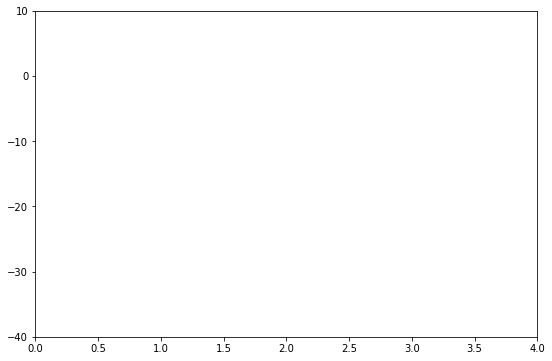

In [28]:
# Construct Plot Separately
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-40, 10)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i,w in enumerate(vals):
    ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
lb = 'true value function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='lower right');